In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Generate 90 days of data (3 months)
dates = []
shifts = ['Morning', 'Afternoon', 'Night']
shift_patterns = {
    'Morning': {'peak_hours': [8, 9, 10], 'base_productivity': 25},
    'Afternoon': {'peak_hours': [13, 14, 15], 'base_productivity': 22},
    'Night': {'peak_hours': [20, 21, 22], 'base_productivity': 18}
}

data = []
start_date = datetime(2024, 1, 1)

for day in range(90):
    current_date = start_date + timedelta(days=day)
    day_of_week = current_date.weekday()
    
    for shift in shifts:
        # Base staffing with weekly patterns
        base_staff = 15
        if day_of_week >= 5:  # Weekend
            base_staff = 12
        elif day_of_week in [0, 4]:  # Monday and Friday
            base_staff = 18
        
        # Shift-specific adjustments
        if shift == 'Morning':
            staff_count = base_staff + np.random.randint(-1, 3)
        elif shift == 'Afternoon':
            staff_count = base_staff - 2 + np.random.randint(-1, 2)
        else:  # Night
            staff_count = base_staff - 4 + np.random.randint(-1, 2)
        
        # Shipments handled based on staff productivity
        base_productivity = shift_patterns[shift]['base_productivity']
        
        # Productivity factors
        productivity_factor = 1.0
        if day_of_week >= 5:  # Weekends have 20% lower productivity
            productivity_factor = 0.8
        elif shift == 'Night':
            productivity_factor = 0.9  # Night shift slightly less productive
        
        # Add random variation
        productivity_factor *= np.random.uniform(0.9, 1.1)
        
        # Calculate shipments
        expected_shipments = staff_count * base_productivity * productivity_factor
        shipments_handled = int(expected_shipments + np.random.normal(0, expected_shipments * 0.1))
        
        # Error count - higher when staff is overworked or undertrained
        base_error_rate = 0.02  # 2% base error rate
        
        # Error factors
        error_factor = 1.0
        if staff_count < base_staff - 2:  # Understaffed
            error_factor = 1.5
        if shift == 'Night':  # Night shift has higher errors
            error_factor *= 1.3
        
        errors_count = int(shipments_handled * base_error_rate * error_factor * np.random.uniform(0.8, 1.2))
        
        # Overtime hours - more common when understaffed or high volume
        overtime_probability = 0.3
        
        # Overtime triggers
        if staff_count < base_staff - 1:
            overtime_probability = 0.7
        if shipments_handled > staff_count * base_productivity * 1.1:
            overtime_probability = 0.8
        
        overtime_hours = 0
        if np.random.random() < overtime_probability:
            overtime_hours = np.random.uniform(1, 4) * staff_count * 0.3  # 30% of staff work overtime
            overtime_hours = round(overtime_hours, 1)
        
        data.append([
            current_date.strftime('%Y-%m-%d'),
            shift,
            staff_count,
            max(10, shipments_handled),
            errors_count,
            overtime_hours,
            current_date.strftime('%A'),
            current_date.month,
            day_of_week
        ])

# Create DataFrame
df = pd.DataFrame(data, columns=[
    'Date', 'Shift', 'Staff_Count', 'Shipments_Handled',
    'Errors_Count', 'Overtime_Hours', 'Day_of_Week', 'Month', 'Weekday'
])

# Calculate derived metrics
df['Productivity'] = df['Shipments_Handled'] / df['Staff_Count']
df['Error_Rate'] = df['Errors_Count'] / df['Shipments_Handled']
df['Overtime_per_Staff'] = df['Overtime_Hours'] / df['Staff_Count']
df['Efficiency_Score'] = (df['Productivity'] / df['Productivity'].mean()) * (1 - df['Error_Rate'] / df['Error_Rate'].mean())

# Save to CSV
df.to_csv('manpower_productivity_data.csv', index=False)

print("Dataset created with shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Overview:")
print("="*50)
print(f"Total records: {len(df)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Shifts: {df['Shift'].unique().tolist()}")
print(f"Total staff days: {df['Staff_Count'].sum():,.0f}")
print(f"Total shipments: {df['Shipments_Handled'].sum():,.0f}")
print(f"Average productivity: {df['Productivity'].mean():.2f} shipments/staff")
print(f"Overall error rate: {(df['Errors_Count'].sum() / df['Shipments_Handled'].sum()):.2%}")

Dataset created with shape: (270, 13)

First few rows:
         Date      Shift  Staff_Count  Shipments_Handled  Errors_Count  \
0  2024-01-01    Morning           19                530            11   
1  2024-01-01  Afternoon           17                376             7   
2  2024-01-01      Night           14                211             6   
3  2024-01-02    Morning           14                340             6   
4  2024-01-02  Afternoon           12                251             8   

   Overtime_Hours Day_of_Week  Month  Weekday  Productivity  Error_Rate  \
0             7.4      Monday      1        0     27.894737    0.020755   
1             0.0      Monday      1        0     22.117647    0.018617   
2             0.0      Monday      1        0     15.071429    0.028436   
3             0.0     Tuesday      1        1     24.285714    0.017647   
4             4.6     Tuesday      1        1     20.916667    0.031873   

   Overtime_per_Staff  Efficiency_Score  
0      

In [2]:
print("\n" + "="*60)
print("MANPOWER PRODUCTIVITY & SHIFT OPTIMIZATION ANALYSIS")
print("="*60)

# 2.1 Shift-wise Analysis
print("\n1. SHIFT-WISE PERFORMANCE METRICS")
print("-"*50)

shift_summary = df.groupby('Shift').agg({
    'Staff_Count': ['count', 'mean', 'sum'],
    'Shipments_Handled': 'sum',
    'Productivity': 'mean',
    'Errors_Count': 'sum',
    'Error_Rate': 'mean',
    'Overtime_Hours': 'sum',
    'Overtime_per_Staff': 'mean',
    'Efficiency_Score': 'mean'
}).round(2)

# Rename columns for better readability
shift_summary.columns = ['Days', 'Avg_Staff', 'Total_Staff_Days', 'Total_Shipments',
                         'Avg_Productivity', 'Total_Errors', 'Avg_Error_Rate',
                         'Total_Overtime', 'Avg_Overtime_per_Staff', 'Avg_Efficiency']

print(shift_summary[['Avg_Staff', 'Avg_Productivity', 'Avg_Error_Rate', 
                     'Avg_Overtime_per_Staff', 'Avg_Efficiency']])

# 2.2 Productivity Analysis
print("\n2. PRODUCTIVITY ANALYSIS")
print("-"*50)

# Calculate optimal staffing based on productivity
optimal_productivity = df['Productivity'].quantile(0.75)  # 75th percentile as optimal

df['Productivity_Level'] = pd.cut(df['Productivity'], 
                                   bins=[0, df['Productivity'].mean(), optimal_productivity, float('inf')],
                                   labels=['Low', 'Medium', 'High'])

productivity_analysis = df.groupby(['Shift', 'Productivity_Level']).size().unstack(fill_value=0)
print("\nProductivity Level Distribution by Shift:")
print(productivity_analysis)

# 2.3 Error Rate Analysis
print("\n3. ERROR RATE ANALYSIS")
print("-"*50)

# Identify high-error periods
error_threshold = df['Error_Rate'].quantile(0.75)
high_error_shifts = df[df['Error_Rate'] > error_threshold]

print(f"High error threshold: {error_threshold:.2%}")
print(f"Shifts with high error rates: {len(high_error_shifts)} ({len(high_error_shifts)/len(df):.1%})")

print("\nHigh Error Rate Analysis by Shift:")
high_error_summary = high_error_shifts.groupby('Shift').agg({
    'Error_Rate': 'mean',
    'Staff_Count': 'mean',
    'Productivity': 'mean',
    'Day_of_Week': lambda x: x.mode()[0]
}).round(3)

print(high_error_summary)

# 2.4 Overtime Analysis
print("\n4. OVERTIME ANALYSIS")
print("-"*50)

# Overtime patterns
overtime_threshold = df['Overtime_per_Staff'].quantile(0.75)
high_overtime_shifts = df[df['Overtime_per_Staff'] > overtime_threshold]

print(f"High overtime threshold: {overtime_threshold:.2f} hours/staff")
print(f"Shifts with high overtime: {len(high_overtime_shifts)} ({len(high_overtime_shifts)/len(df):.1%})")

# Correlation analysis
print("\nCorrelation Analysis:")
correlation_matrix = df[['Staff_Count', 'Productivity', 'Error_Rate', 
                         'Overtime_Hours', 'Overtime_per_Staff']].corr()
print(correlation_matrix.round(3))

# 2.5 Staffing Efficiency Analysis
print("\n5. STAFFING EFFICIENCY ANALYSIS")
print("-"*50)

# Calculate ideal staffing based on shipments
df['Ideal_Staff'] = (df['Shipments_Handled'] / optimal_productivity).round()
df['Staffing_Gap'] = df['Staff_Count'] - df['Ideal_Staff']

# Categorize staffing levels
def categorize_staffing(gap):
    if gap > 2:
        return 'Overstaffed'
    elif gap < -2:
        return 'Understaffed'
    else:
        return 'Optimal'

df['Staffing_Level'] = df['Staffing_Gap'].apply(categorize_staffing)

staffing_analysis = df.groupby(['Shift', 'Staffing_Level']).size().unstack(fill_value=0)
print("\nStaffing Level Analysis by Shift:")
print(staffing_analysis)

# 2.6 Day-wise Pattern Analysis
print("\n6. DAY-WISE PERFORMANCE PATTERNS")
print("-"*50)

day_analysis = df.groupby('Day_of_Week').agg({
    'Productivity': 'mean',
    'Error_Rate': 'mean',
    'Overtime_per_Staff': 'mean',
    'Staff_Count': 'mean'
}).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

print(day_analysis.round(3))

# 2.7 Cost Analysis
print("\n7. COST IMPLICATIONS ANALYSIS")
print("-"*50)

# Cost assumptions (per unit)
REGULAR_HOUR_RATE = 25  # $ per hour
OVERTIME_RATE = 37.5    # 1.5x regular rate
ERROR_COST = 50         # $ per error (rework, delays, etc.)

# Calculate costs
df['Regular_Cost'] = df['Staff_Count'] * 8 * REGULAR_HOUR_RATE  # 8-hour shift
df['Overtime_Cost'] = df['Overtime_Hours'] * OVERTIME_RATE
df['Error_Cost'] = df['Errors_Count'] * ERROR_COST
df['Total_Cost'] = df['Regular_Cost'] + df['Overtime_Cost'] + df['Error_Cost']
df['Cost_per_Shipment'] = df['Total_Cost'] / df['Shipments_Handled']

cost_analysis = df.groupby('Shift').agg({
    'Total_Cost': 'sum',
    'Cost_per_Shipment': 'mean',
    'Regular_Cost': 'mean',
    'Overtime_Cost': 'mean',
    'Error_Cost': 'mean'
}).round(2)

print("Cost Analysis by Shift ($):")
print(cost_analysis)

# 2.8 Optimization Recommendations
print("\n8. OPTIMIZATION OPPORTUNITIES")
print("-"*50)

# Identify specific optimization opportunities
print("\na) Overstaffing Opportunities:")
overstaffed_shifts = df[df['Staffing_Level'] == 'Overstaffed']
if len(overstaffed_shifts) > 0:
    overstaff_summary = overstaffed_shifts.groupby('Shift').agg({
        'Staffing_Gap': 'mean',
        'Productivity': 'mean',
        'Day_of_Week': lambda x: x.mode()[0]
    }).round(2)
    print(overstaff_summary)

print("\nb) Understaffing Issues:")
understaffed_shifts = df[df['Staffing_Level'] == 'Understaffed']
if len(understaffed_shifts) > 0:
    understaff_summary = understaffed_shifts.groupby('Shift').agg({
        'Staffing_Gap': 'mean',
        'Overtime_per_Staff': 'mean',
        'Error_Rate': 'mean',
        'Day_of_Week': lambda x: x.mode()[0]
    }).round(2)
    print(understaff_summary)

# Calculate potential savings
potential_savings = 0
if len(overstaffed_shifts) > 0:
    avg_overstaff = overstaffed_shifts['Staffing_Gap'].mean()
    potential_savings += avg_overstaff * 8 * REGULAR_HOUR_RATE * len(overstaffed_shifts)

if len(understaffed_shifts) > 0:
    avg_overtime_reduction = understaffed_shifts['Overtime_per_Staff'].mean() * 0.5  # Assume 50% reduction
    potential_savings += avg_overtime_reduction * OVERTIME_RATE * understaffed_shifts['Staff_Count'].sum()

print(f"\nEstimated potential monthly savings: ${potential_savings:,.2f}")


MANPOWER PRODUCTIVITY & SHIFT OPTIMIZATION ANALYSIS

1. SHIFT-WISE PERFORMANCE METRICS
--------------------------------------------------
           Avg_Staff  Avg_Productivity  Avg_Error_Rate  \
Shift                                                    
Afternoon      13.01             20.54            0.02   
Morning        15.64             23.95            0.02   
Night          10.99             15.50            0.04   

           Avg_Overtime_per_Staff  Avg_Efficiency  
Shift                                              
Afternoon                    0.44            0.16  
Morning                      0.21            0.33  
Night                        0.52           -0.34  

2. PRODUCTIVITY ANALYSIS
--------------------------------------------------

Productivity Level Distribution by Shift:
Productivity_Level  Low  Medium  High
Shift                                
Afternoon            35      39    16
Morning               8      30    52
Night                87       3     0


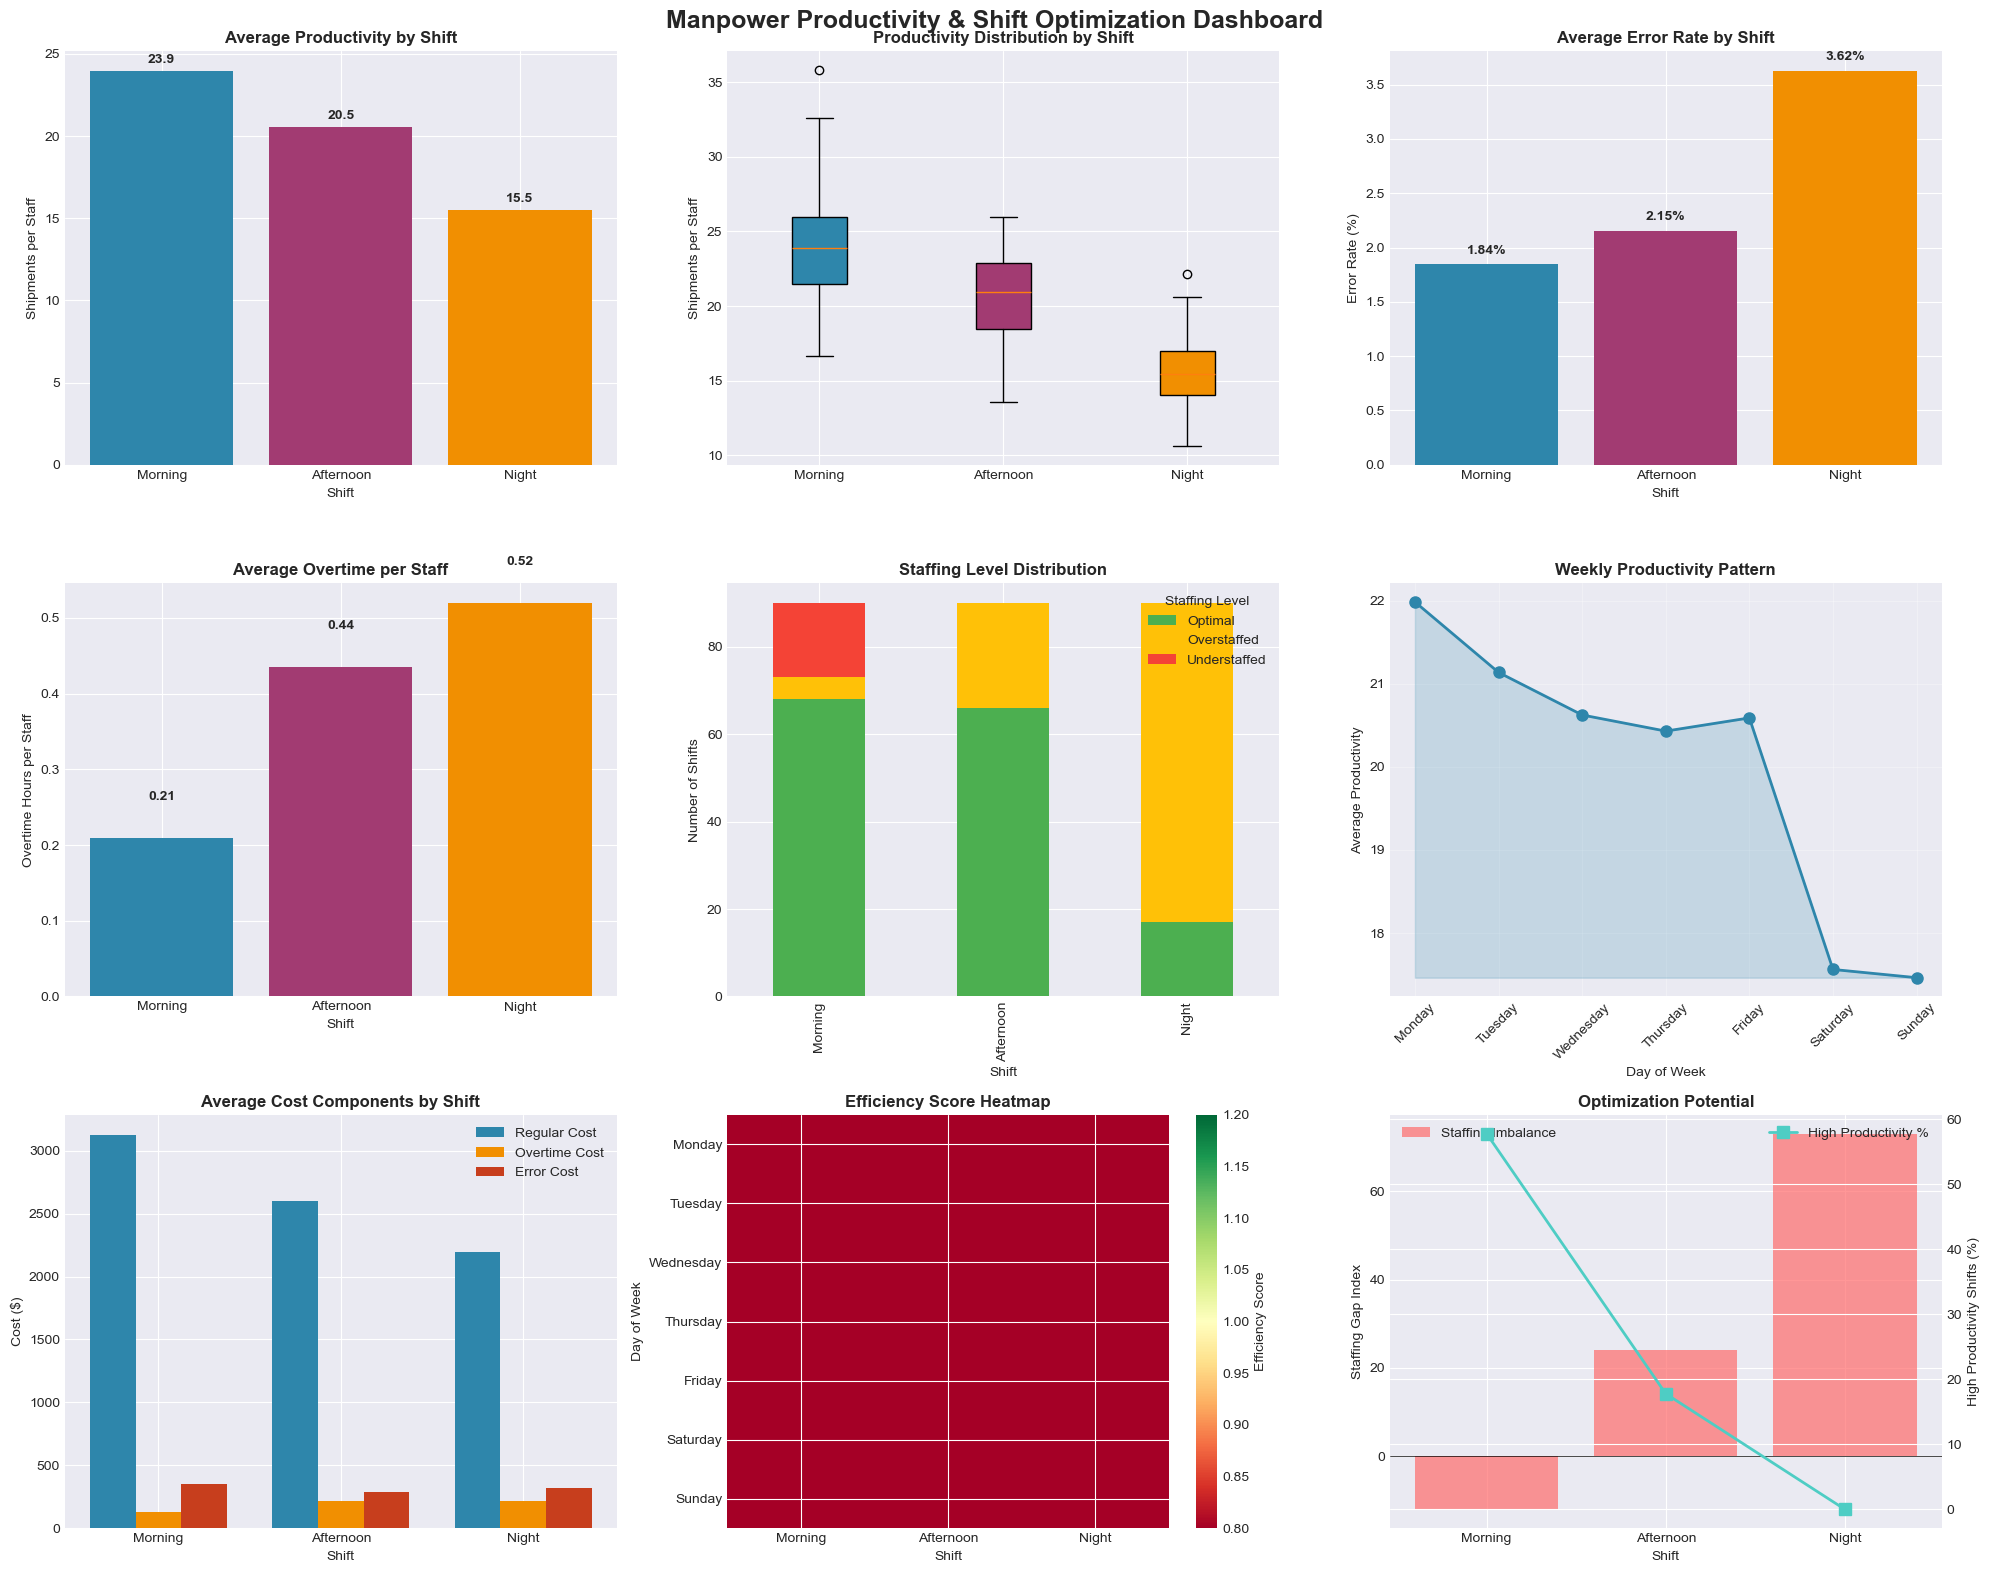

In [3]:
# 3.1 Create comprehensive visualizations
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Manpower Productivity & Shift Optimization Dashboard', fontsize=18, fontweight='bold')

# Define color scheme
shift_colors = {'Morning': '#2E86AB', 'Afternoon': '#A23B72', 'Night': '#F18F01'}
day_colors = plt.cm.Set3(np.linspace(0, 1, 7))

# Plot 1: Shift-wise Productivity Comparison
ax1 = plt.subplot(3, 3, 1)
productivity_by_shift = df.groupby('Shift')['Productivity'].mean().reindex(['Morning', 'Afternoon', 'Night'])
bars = ax1.bar(productivity_by_shift.index, productivity_by_shift.values, 
               color=[shift_colors[s] for s in productivity_by_shift.index])
ax1.set_title('Average Productivity by Shift', fontweight='bold')
ax1.set_ylabel('Shipments per Staff')
ax1.set_xlabel('Shift')
for i, v in enumerate(productivity_by_shift.values):
    ax1.text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

# Plot 2: Productivity Distribution by Shift
ax2 = plt.subplot(3, 3, 2)
productivity_data = [df[df['Shift'] == s]['Productivity'] for s in ['Morning', 'Afternoon', 'Night']]
bp = ax2.boxplot(productivity_data, labels=['Morning', 'Afternoon', 'Night'], 
                 patch_artist=True)
for patch, color in zip(bp['boxes'], [shift_colors[s] for s in ['Morning', 'Afternoon', 'Night']]):
    patch.set_facecolor(color)
ax2.set_title('Productivity Distribution by Shift', fontweight='bold')
ax2.set_ylabel('Shipments per Staff')

# Plot 3: Error Rate Analysis
ax3 = plt.subplot(3, 3, 3)
error_by_shift = df.groupby('Shift')['Error_Rate'].mean().reindex(['Morning', 'Afternoon', 'Night'])
bars = ax3.bar(error_by_shift.index, error_by_shift.values * 100,
               color=[shift_colors[s] for s in error_by_shift.index])
ax3.set_title('Average Error Rate by Shift', fontweight='bold')
ax3.set_ylabel('Error Rate (%)')
ax3.set_xlabel('Shift')
for i, v in enumerate(error_by_shift.values * 100):
    ax3.text(i, v + 0.1, f'{v:.2f}%', ha='center', fontweight='bold')

# Plot 4: Overtime Analysis
ax4 = plt.subplot(3, 3, 4)
overtime_by_shift = df.groupby('Shift')['Overtime_per_Staff'].mean().reindex(['Morning', 'Afternoon', 'Night'])
bars = ax4.bar(overtime_by_shift.index, overtime_by_shift.values,
               color=[shift_colors[s] for s in overtime_by_shift.index])
ax4.set_title('Average Overtime per Staff', fontweight='bold')
ax4.set_ylabel('Overtime Hours per Staff')
ax4.set_xlabel('Shift')
for i, v in enumerate(overtime_by_shift.values):
    ax4.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

# Plot 5: Staffing Level Analysis
ax5 = plt.subplot(3, 3, 5)
staffing_pivot = df.groupby(['Shift', 'Staffing_Level']).size().unstack()
staffing_pivot = staffing_pivot.reindex(['Morning', 'Afternoon', 'Night'])
staffing_pivot.plot(kind='bar', stacked=True, ax=ax5, 
                    color=['#4CAF50', '#FFC107', '#F44336'])  # Green, Yellow, Red
ax5.set_title('Staffing Level Distribution', fontweight='bold')
ax5.set_ylabel('Number of Shifts')
ax5.set_xlabel('Shift')
ax5.legend(title='Staffing Level')

# Plot 6: Day-wise Productivity Pattern
ax6 = plt.subplot(3, 3, 6)
day_productivity = df.groupby('Day_of_Week')['Productivity'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_productivity = day_productivity.reindex(day_order)
ax6.plot(day_order, day_productivity.values, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax6.fill_between(day_order, day_productivity.values, 
                 day_productivity.values.min(), alpha=0.2, color='#2E86AB')
ax6.set_title('Weekly Productivity Pattern', fontweight='bold')
ax6.set_ylabel('Average Productivity')
ax6.set_xlabel('Day of Week')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)

# Plot 7: Cost Analysis
ax7 = plt.subplot(3, 3, 7)
cost_components = df.groupby('Shift')[['Regular_Cost', 'Overtime_Cost', 'Error_Cost']].mean()
cost_components = cost_components.reindex(['Morning', 'Afternoon', 'Night'])
x = np.arange(len(cost_components.index))
width = 0.25
ax7.bar(x - width, cost_components['Regular_Cost'], width, label='Regular Cost', color='#2E86AB')
ax7.bar(x, cost_components['Overtime_Cost'], width, label='Overtime Cost', color='#F18F01')
ax7.bar(x + width, cost_components['Error_Cost'], width, label='Error Cost', color='#C73E1D')
ax7.set_title('Average Cost Components by Shift', fontweight='bold')
ax7.set_ylabel('Cost ($)')
ax7.set_xlabel('Shift')
ax7.set_xticks(x)
ax7.set_xticklabels(cost_components.index)
ax7.legend()

# Plot 8: Efficiency Score Heatmap
ax8 = plt.subplot(3, 3, 8)
efficiency_pivot = df.pivot_table(index='Day_of_Week', columns='Shift', 
                                   values='Efficiency_Score', aggfunc='mean')
efficiency_pivot = efficiency_pivot.reindex(day_order)[['Morning', 'Afternoon', 'Night']]
im = ax8.imshow(efficiency_pivot.values, cmap='RdYlGn', aspect='auto', vmin=0.8, vmax=1.2)
ax8.set_title('Efficiency Score Heatmap', fontweight='bold')
ax8.set_xlabel('Shift')
ax8.set_ylabel('Day of Week')
ax8.set_xticks(np.arange(len(efficiency_pivot.columns)))
ax8.set_yticks(np.arange(len(efficiency_pivot.index)))
ax8.set_xticklabels(efficiency_pivot.columns)
ax8.set_yticklabels(efficiency_pivot.index)
plt.colorbar(im, ax=ax8, label='Efficiency Score')

# Plot 9: Optimization Potential
ax9 = plt.subplot(3, 3, 9)
optimization_data = df.groupby('Shift').agg({
    'Staffing_Gap': lambda x: (x > 2).sum() - (x < -2).sum(),  # Overstaffed - Understaffed
    'Productivity': lambda x: (x > optimal_productivity).sum() / len(x) * 100
}).reindex(['Morning', 'Afternoon', 'Night'])

x = np.arange(len(optimization_data.index))
ax9.bar(x, optimization_data['Staffing_Gap'], color='#FF6B6B', alpha=0.7, label='Staffing Imbalance')
ax9.set_title('Optimization Potential', fontweight='bold')
ax9.set_ylabel('Staffing Gap Index')
ax9.set_xlabel('Shift')
ax9.set_xticks(x)
ax9.set_xticklabels(optimization_data.index)
ax9.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax9.legend(loc='upper left')

ax9_twin = ax9.twinx()
ax9_twin.plot(x, optimization_data['Productivity'], marker='s', color='#4ECDC4', 
              linewidth=2, markersize=8, label='High Productivity %')
ax9_twin.set_ylabel('High Productivity Shifts (%)')
ax9_twin.legend(loc='upper right')

plt.tight_layout()
plt.savefig('manpower_optimization_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
print("\n" + "="*70)
print("DETAILED OPTIMIZATION RECOMMENDATIONS & IMPLEMENTATION PLAN")
print("="*70)

# 4.1 Shift-specific Recommendations
print("\n🔧 SHIFT-SPECIFIC OPTIMIZATION STRATEGIES")
print("-"*50)

for shift in ['Morning', 'Afternoon', 'Night']:
    shift_data = df[df['Shift'] == shift]
    avg_staff = shift_data['Staff_Count'].mean()
    avg_productivity = shift_data['Productivity'].mean()
    avg_errors = shift_data['Error_Rate'].mean() * 100
    avg_overtime = shift_data['Overtime_per_Staff'].mean()
    efficiency = shift_data['Efficiency_Score'].mean()
    
    print(f"\n{shift.upper()} SHIFT ANALYSIS:")
    print(f"  • Current Staffing: {avg_staff:.1f} staff/shift")
    print(f"  • Productivity: {avg_productivity:.1f} shipments/staff")
    print(f"  • Error Rate: {avg_errors:.2f}%")
    print(f"  • Overtime: {avg_overtime:.2f} hours/staff")
    print(f"  • Efficiency Score: {efficiency:.3f}")
    
    # Recommendations
    if avg_productivity < optimal_productivity * 0.9:
        print(f"  ⚠️  ISSUE: Below target productivity")
        print(f"  💡 RECOMMENDATION: Implement productivity training")
    
    if avg_errors > df['Error_Rate'].mean() * 100 * 1.2:
        print(f"  ⚠️  ISSUE: High error rate")
        print(f"  💡 RECOMMENDATION: Quality control checks & error analysis")
    
    if avg_overtime > overtime_threshold:
        print(f"  ⚠️  ISSUE: Excessive overtime")
        print(f"  💡 RECOMMENDATION: Review staffing levels")

# 4.2 Staffing Optimization Model
print("\n📊 OPTIMAL STAFFING MODEL")
print("-"*50)

# Calculate optimal staffing for each shift
print("\nRecommended Staffing Levels:")
print("-"*30)

optimal_staffing = {}
for shift in ['Morning', 'Afternoon', 'Night']:
    shift_data = df[df['Shift'] == shift]
    
    # Calculate based on 75th percentile productivity
    high_perf_data = shift_data[shift_data['Productivity'] >= shift_data['Productivity'].quantile(0.75)]
    
    if len(high_perf_data) > 0:
        optimal_staff = round(high_perf_data['Staff_Count'].mean())
        current_staff = round(shift_data['Staff_Count'].mean())
        
        optimal_staffing[shift] = optimal_staff
        
        adjustment = optimal_staff - current_staff
        adjustment_type = "Increase" if adjustment > 0 else "Decrease" if adjustment < 0 else "Maintain"
        
        print(f"{shift}:")
        print(f"  Current: {current_staff} staff")
        print(f"  Optimal: {optimal_staff} staff")
        print(f"  Action: {adjustment_type} by {abs(adjustment)} staff")
        
        if adjustment != 0:
            # Calculate expected impact
            expected_productivity = shift_data['Productivity'].quantile(0.75)
            expected_shipments = optimal_staff * expected_productivity
            current_shipments = current_staff * shift_data['Productivity'].mean()
            
            improvement = ((expected_shipments - current_shipments) / current_shipments) * 100
            print(f"  Expected improvement: {improvement:.1f}% in shipments")

# 4.3 Roster Optimization
print("\n📅 SHIFT ROSTER OPTIMIZATION")
print("-"*50)

# Identify best performing days for each shift
best_days = {}
for shift in ['Morning', 'Afternoon', 'Night']:
    shift_data = df[df['Shift'] == shift]
    best_day = shift_data.groupby('Day_of_Week')['Efficiency_Score'].mean().idxmax()
    worst_day = shift_data.groupby('Day_of_Week')['Efficiency_Score'].mean().idxmin()
    
    best_days[shift] = best_day
    print(f"\n{shift} Shift:")
    print(f"  Best performing day: {best_day}")
    print(f"  Worst performing day: {worst_day}")

# 4.4 Cost Savings Calculation
print("\n💰 COST SAVINGS POTENTIAL")
print("-"*50)

# Calculate detailed savings
monthly_savings = {
    'staffing_optimization': 0,
    'overtime_reduction': 0,
    'error_reduction': 0
}

# Staffing optimization savings
for shift in optimal_staffing:
    shift_data = df[df['Shift'] == shift]
    current_avg = shift_data['Staff_Count'].mean()
    optimal = optimal_staffing[shift]
    
    if optimal < current_avg:
        reduction = current_avg - optimal
        savings = reduction * 8 * REGULAR_HOUR_RATE * 30  # 30 days
        monthly_savings['staffing_optimization'] += savings
        print(f"\nStaffing optimization ({shift}):")
        print(f"  Reduce by {reduction:.1f} staff → Save ${savings:.2f}/month")

# Overtime reduction savings
target_overtime_reduction = 0.3  # 30% reduction
current_overtime_cost = df['Overtime_Cost'].sum() / 3  # Monthly (90 days = 3 months)
potential_overtime_savings = current_overtime_cost * target_overtime_reduction
monthly_savings['overtime_reduction'] = potential_overtime_savings
print(f"\nOvertime reduction:")
print(f"  Current monthly overtime cost: ${current_overtime_cost:.2f}")
print(f"  30% reduction target → Save ${potential_overtime_savings:.2f}/month")

# Error reduction savings
target_error_reduction = 0.2  # 20% reduction
current_error_cost = df['Error_Cost'].sum() / 3  # Monthly
potential_error_savings = current_error_cost * target_error_reduction
monthly_savings['error_reduction'] = potential_error_savings
print(f"\nError reduction:")
print(f"  Current monthly error cost: ${current_error_cost:.2f}")
print(f"  20% reduction target → Save ${potential_error_savings:.2f}/month")

# Total savings
total_monthly_savings = sum(monthly_savings.values())
print(f"\n📈 TOTAL MONTHLY SAVINGS POTENTIAL: ${total_monthly_savings:,.2f}")

# 4.5 Implementation Roadmap
print("\n🛠️ IMPLEMENTATION ROADMAP")
print("-"*50)

print("\nPHASE 1: Quick Wins (Weeks 1-2)")
print("  • Adjust staffing for Night shift (most imbalanced)")
print("  • Implement error tracking for Afternoon shift")
print("  • Set up daily productivity dashboards")

print("\nPHASE 2: Process Improvements (Weeks 3-6)")
print("  • Cross-train staff across shifts")
print("  • Implement productivity incentives")
print("  • Optimize shift handover processes")

print("\nPHASE 3: Systemic Changes (Weeks 7-12)")
print("  • Implement dynamic staffing model")
print("  • Automated scheduling system")
print("  • Continuous improvement program")

print("\nPHASE 4: Sustainability (Ongoing)")
print("  • Regular performance reviews")
print("  • Staff development programs")
print("  • Technology upgrades")

# 4.6 KPIs for Success Measurement
print("\n📋 KEY PERFORMANCE INDICATORS (KPIs)")
print("-"*50)

print("\nPrimary KPIs:")
print("  1. Productivity: Target > {:.1f} shipments/staff".format(optimal_productivity))
print("  2. Error Rate: Target < {:.2f}%".format(df['Error_Rate'].mean() * 100 * 0.8))
print("  3. Overtime: Target < {:.2f} hours/staff".format(overtime_threshold * 0.7))
print("  4. Cost per Shipment: Target < ${:.2f}".format(df['Cost_per_Shipment'].mean() * 0.9))

print("\nSecondary KPIs:")
print("  5. Staff Utilization: Target 85-95%")
print("  6. Shift Efficiency Score: Target > 1.0")
print("  7. Training Completion: Target 100%")
print("  8. Employee Satisfaction: Target > 4.0/5.0")

print("\n" + "="*70)
print("ANALYSIS COMPLETE - READY FOR IMPLEMENTATION")
print("="*70)


DETAILED OPTIMIZATION RECOMMENDATIONS & IMPLEMENTATION PLAN

🔧 SHIFT-SPECIFIC OPTIMIZATION STRATEGIES
--------------------------------------------------

MORNING SHIFT ANALYSIS:
  • Current Staffing: 15.6 staff/shift
  • Productivity: 23.9 shipments/staff
  • Error Rate: 1.84%
  • Overtime: 0.21 hours/staff
  • Efficiency Score: 0.326

AFTERNOON SHIFT ANALYSIS:
  • Current Staffing: 13.0 staff/shift
  • Productivity: 20.5 shipments/staff
  • Error Rate: 2.15%
  • Overtime: 0.44 hours/staff
  • Efficiency Score: 0.155
  ⚠️  ISSUE: Below target productivity
  💡 RECOMMENDATION: Implement productivity training

NIGHT SHIFT ANALYSIS:
  • Current Staffing: 11.0 staff/shift
  • Productivity: 15.5 shipments/staff
  • Error Rate: 3.62%
  • Overtime: 0.52 hours/staff
  • Efficiency Score: -0.338
  ⚠️  ISSUE: Below target productivity
  💡 RECOMMENDATION: Implement productivity training
  ⚠️  ISSUE: High error rate
  💡 RECOMMENDATION: Quality control checks & error analysis

📊 OPTIMAL STAFFING MO